In [3]:
from common_funcs import *

In [217]:
# Install packages for dealing with emojis for text cleaning.
import re, sys, emoji

!{sys.executable} -m pip install emot

In [201]:
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO

# EDA and data cleaning

In [4]:
df = pd.read_pickle('data/reddit_df_final')

In [5]:
df.shape

(257562, 121)

## EDA
Before paring down the df to only the relevant columns, let's do some EDA.

### Top ten countries by number of posts
It is not surprising that Ukraine features highest considering the Reddit search was done with Ukraine-themed search queries.

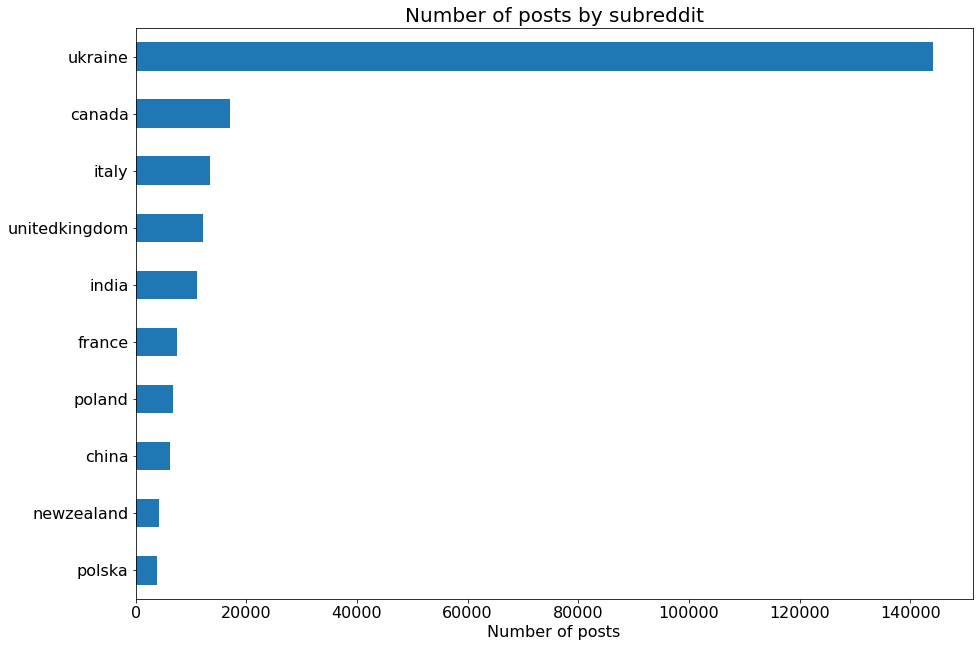

In [70]:
df.country.value_counts()[:10].sort_values().plot(kind='barh', figsize=(15, 10.5));
plt.xlabel('Number of posts', fontsize=(16));
plt.title('Number of posts by subreddit', fontsize=(20));
plt.yticks(fontsize=16);
plt.xticks(fontsize=16);

Is one poster dominating the discussion in a way that could skew results? It does not appear so.

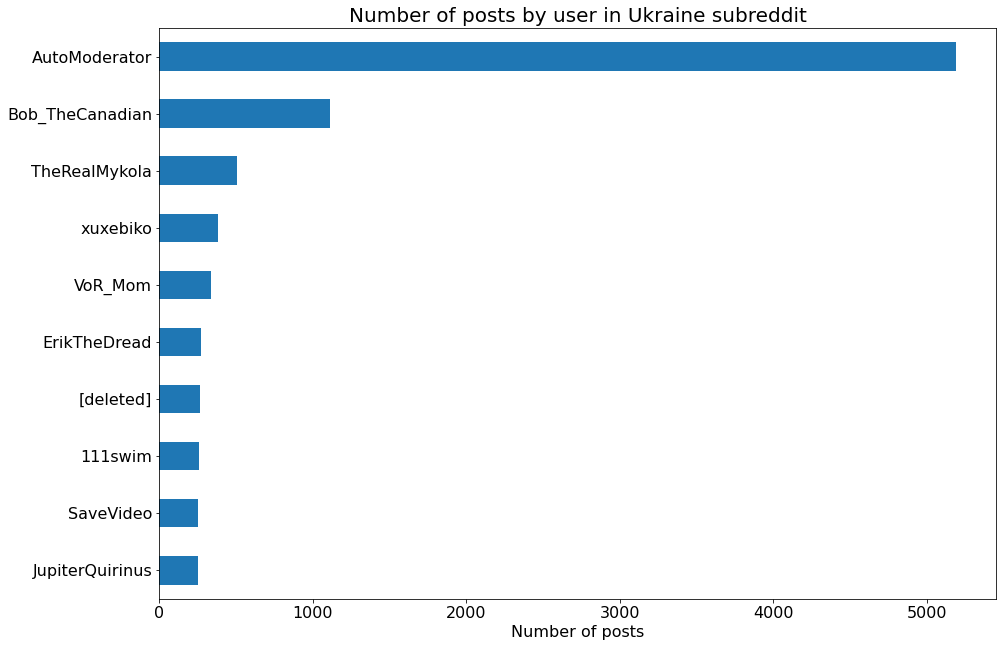

In [71]:
df.loc[df.country=='ukraine', 'author'].value_counts()[:10].sort_values().plot(kind='barh', figsize = (15, 10.5));
plt.xlabel('Number of posts', fontsize=(16));
plt.title('Number of posts by user in Ukraine subreddit', fontsize=(20));
plt.yticks(fontsize=16);
plt.xticks(fontsize=16);

In [78]:
df.loc[df.country=='ukraine', 'author'].value_counts()

AutoModerator           5194
Bob_TheCanadian         1115
TheRealMykola            505
xuxebiko                 384
VoR_Mom                  335
                        ... 
Dandollo                   1
WealthWithoutWork          1
Mutilator1991              1
Head_Perspective_783       1
WolfgangBaumgart           1
Name: author, Length: 50158, dtype: int64

In [90]:
df.loc[df.country=='ukraine', 'author'].value_counts().sort_values(ascending=True)[:10000]

alienpreacher      1
weirdarchivist     1
panzerboye         1
You_Again-_-       1
tommy_dakota       1
                  ..
claudecardinal     1
TraderBase         1
andybb311          1
Schmucka_Jung      1
BussimusMaximus    1
Name: author, Length: 10000, dtype: int64

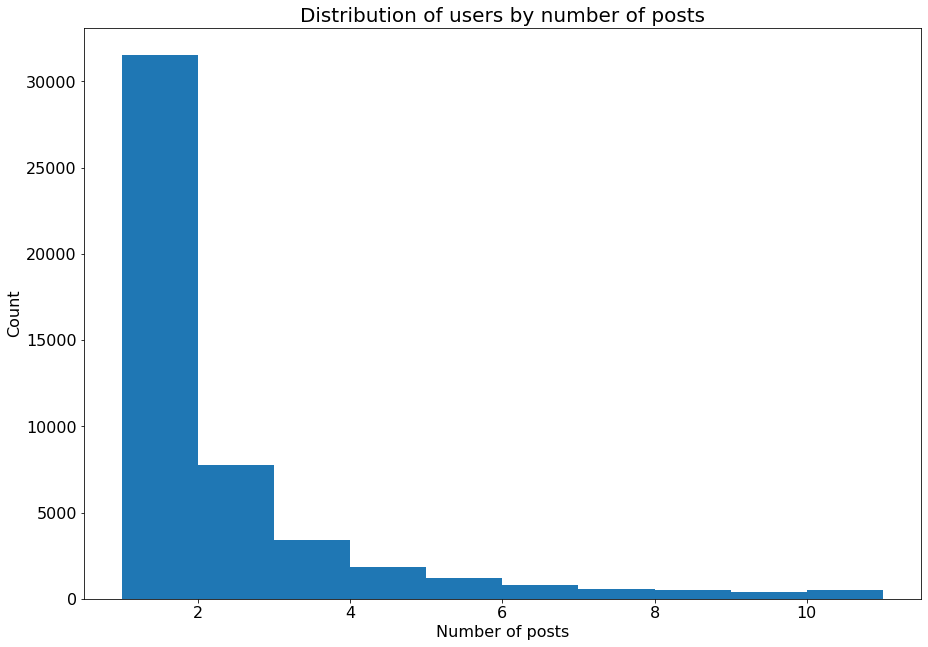

In [110]:
df.loc[df.country=='ukraine', 'author'].value_counts().apply(lambda x: x if x < 12 else np.nan).sort_values(ascending=False).plot(kind='hist', figsize = (15, 10.5));
plt.xlabel('Number of posts', fontsize=(16));
plt.title('Number of users', fontsize=(20));
plt.ylabel('Count', fontsize=16)
plt.yticks(fontsize=16);
plt.xticks(fontsize=16);
plt.title('Distribution of users by number of posts', fontsize=20);

In [64]:
# Percent of columns that have equal values for 'country' and 'subreddit'
df[['country', 'subreddit']].apply(lambda x: x.str.lower()).apply(lambda x: x[0] == x[1], axis=1).sum()/df[['country', 'subreddit']].shape[0]

0.9956554150068722

This shows that the scraped data does not indicate country of the poster.

## Cleaning
We need to cut down on the columns to just the ones relevant for this project.

In [132]:
text_df = df[['body', 'subreddit', 'country', 'Country', 'comments_or_subs', 'selftext', 'title', 'democracy_score', 'GDP', 'abstained']]
text_df = text_df.copy() # To avoid annoying copy warnings from pd.
print(text_df.shape)
text_df.head()

(257562, 10)


,body,subreddit,country,Country,comments_or_subs,selftext,title,democracy_score,GDP,abstained
0,"&gt; Indian students walk out of Kharkiv, as b...",india,india,india,comments,NaN,NaN,6.91,2946061.0,True
1,The Kremlin readout of the Modi-Putin telephon...,india,india,india,comments,NaN,NaN,6.91,2946061.0,True
2,"Russia is part of the UNGA, everyone in the bo...",india,india,india,comments,NaN,NaN,6.91,2946061.0,True
3,Hopefully one thing this tradgedy has taught u...,india,india,india,comments,NaN,NaN,6.91,2946061.0,True
4,Look at a map of India and its surrounding cou...,india,india,india,comments,NaN,NaN,6.91,2946061.0,True


## Clean up GDP column

In [133]:
# Which countries are missing GDP data? Remove 'Polska' because this is just Polish for Poland. Redundant.
countries_missing_GDP = list(text_df[text_df.GDP.isna()].country.unique())
countries_missing_GDP.remove('polska')
countries_missing_GDP

['pakistan',
 'saudiarabia',
 'switzerland',
 'spain',
 'poland',
 'belarus',
 'ukraine',
 'cuba',
 'israel',
 'uae']

In [134]:
all_countries_GDP = pd.read_pickle('data/all_countries_GDP')

In [135]:
all_countries_GDP.Country = all_countries_GDP.Country.str.lower()
all_countries_GDP.set_index('Country', inplace=True)
all_countries_GDP.head()

,Region,GDP
Country,,
unitedstates,Americas,22939580.0
china,Asia,16862979.0
japan,Asia,5103110.0
germany,Europe,4230172.0
unitedkingdom,Europe,3108416.0


In [136]:
all_countries_GDP.rename(index={'unitedarabemirates':'uae', 'unitedstates':'unitedstatesofamerica'},inplace=True)

In [137]:
def return_GDP(country, df=all_countries_GDP):
    return df.loc[country, 'GDP']

In [138]:
text_df.GDP = text_df.country.apply(lambda x: return_GDP(x) if x != 'polska' else np.nan)

In [139]:
text_df[text_df.GDP.isna()].country.unique()

array(['polska', 'cuba'], dtype=object)

Cuba is missing GDP. Will fill in manually.

In [140]:
text_df.loc[text_df.country=='cuba', 'GDP'] = 254.865e9

In [141]:
# Did it work? Do all countries have GDP info? Yes.
text_df[text_df.GDP.isna()].country.unique()

array(['polska'], dtype=object)

In [142]:
# Are there any rows that contain absolutely no comments at all?
text_df[(text_df.selftext.isna()) & (text_df.body.isna()) & (text_df.title.isna())]
# Just one.

,body,subreddit,country,Country,comments_or_subs,selftext,title,democracy_score,GDP,abstained
16107,NaN,NaN,germany,germany,comments,NaN,NaN,8.67,4230172.0,False


In [143]:
# Do any rows contain both 'body' and 'selftext'? No, so we will merge these two rows.
text_df[(~text_df.selftext.isna()) & (~text_df.body.isna())]

,body,subreddit,country,Country,comments_or_subs,selftext,title,democracy_score,GDP,abstained


In [144]:
text_df['text'] = text_df.selftext.combine_first(text_df.body)
text_df.drop(columns=['body', 'selftext'], inplace=True)

In [145]:
text_df[(~text_df.text.isna()) & (~text_df.title.isna())]

,subreddit,country,Country,comments_or_subs,title,democracy_score,GDP,abstained,text
9945,india,india,india,subs,@ZelenskyyUa - Spoke with Prime Minister @nare...,6.91,2946061.0,True,Informed of the course of Ukraine repulsing R...
9946,india,india,india,subs,We're being cowards.,6.91,2946061.0,True,"This is a disgrace. We, who pride ourselves on..."
9947,india,india,india,subs,WHY ARE WE NOT DOING ANYTHING TO HELP UKRAINE?,6.91,2946061.0,True,[removed]
9948,india,india,india,subs,"War is bad, and prayers with Ukraine, but USA ...",6.91,2946061.0,True,The USA has destroyed many countries waging wa...
9949,india,india,india,subs,"In 1998, UN assembly passed the resolution aga...",6.91,2946061.0,True,I want to tell is that the current russia-ukr...
...,...,...,...,...,...,...,...,...,...
257543,UAE,uae,NaN,subs,what is the view of the uae government towards...,NaN,415158.0,NaN,So the uae being a country that has opposed de...
257546,UAE,uae,NaN,subs,🇺🇦 Everyone please support Ukraine 1 Vote = 1 ...,NaN,415158.0,NaN,🇺🇦 Everyone please support Ukraine 1 Vote = 1 ...
257547,UAE,uae,NaN,subs,Stop war in Ukraine,NaN,415158.0,NaN,Please support the Ukrainian defenders. \n\nwe...
257548,UAE,uae,NaN,subs,Sheikh Mohamed bin Zayed stresses peaceful sol...,NaN,415158.0,NaN,"Sheikh Mohamed bin Zayed, Crown Prince of Abu ..."


In [146]:
# Where ever there is an empty text field, fill it with the title field.
text_df.loc[text_df.text.isna(), 'text'] = text_df.loc[text_df.text.isna(), 'title']

In [147]:
# Are there differences in values for subreddit and country columns? Does the 'country' column have any nulls?
display(text_df[(text_df.subreddit.str.lower() != text_df.country) & (~text_df.subreddit.isna())])
print(text_df.country.isna().sum())
# No and no. So just drop subreddit and Country columns.

,subreddit,country,Country,comments_or_subs,title,democracy_score,GDP,abstained,text


0


In [161]:
text_df.drop(columns=['Country', 'subreddit', 'title'], inplace=True, errors='ignore')

## Cleaning the 'abstained' column

In [153]:
# What about the 'abstained' column? Any missing values?
countries_missing_abstained_data = list(text_df.country[text_df.abstained.isna()].unique())
countries_missing_abstained_data

['pakistan',
 'saudiarabia',
 'switzerland',
 'spain',
 'poland',
 'polska',
 'belarus',
 'ukraine',
 'israel',
 'uae']

In [155]:
for country in countries_missing_abstained_data:
    if country == 'pakistan' or country == 'belarus':
        text_df.loc[text_df['country'] == country, 'abstained'] = True
    else:
        text_df.loc[text_df['country'] == country, 'abstained'] = False

In [170]:
text_df.text = text_df.text.astype('str')

In [171]:
text_df.to_pickle('data/text_df')

In [182]:
# Print number of terms and number of documents in the corpus.
num_terms = sum([len(d.split(' ')) for d in text_df.text])
print(f'Number of terms: {num_terms}')
print(f'Number of documents: {len(text_df.text)}')

Number of terms: 14399110
Number of documents: 257562


Now on to text pre-processing in the next notebook.